In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from Utils.dataset import PreloadedDataset
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

import math

In [2]:
# device = torch.device('cuda') if torch.cuda.is_available() else "cpu"ArithmeticError
device = torch.device('cpu')
device

device(type='cpu')

Loaded MNIST with 1 samples


IndexError: index 1 is out of bounds for dimension 0 with size 1

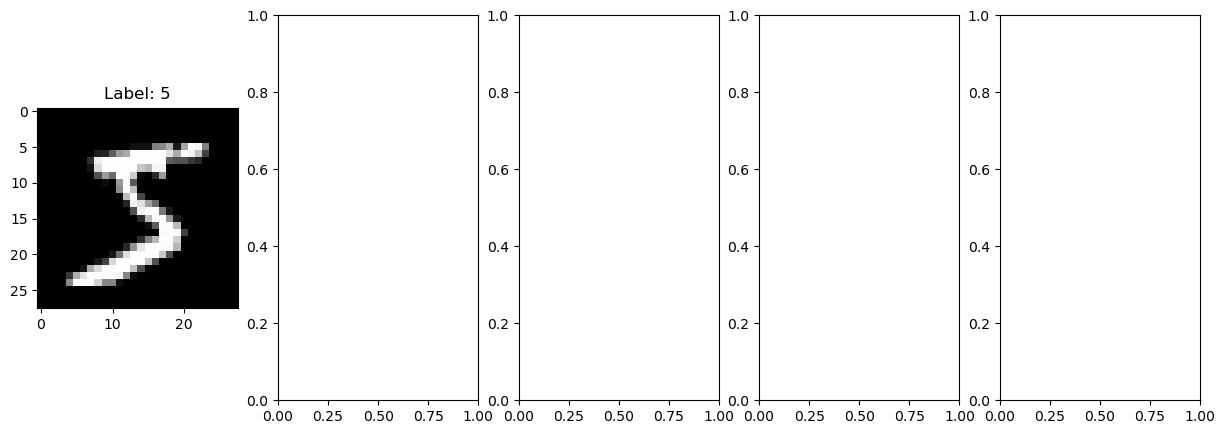

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

subset_size = 1
raw_dataset = datasets.MNIST(root="../Datasets/", train=True, transform=transform, download=False)
raw_dataset = torch.utils.data.Subset(raw_dataset, range(subset_size))

positive_dataset = PreloadedDataset.from_dataset(raw_dataset, transforms.ToTensor(), device)
print(f'Loaded MNIST with {len(positive_dataset)} samples')
# show first samples
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow(np.squeeze(positive_dataset[i][0].numpy()), cmap='gray')
    axs[i].set_title(f"Label: {positive_dataset[i][1]}")
plt.show()

In [4]:
def mix_images(x1, x2, steps=10):
    mask = torch.bernoulli(torch.ones((28,28))*0.5).unsqueeze(0).unsqueeze(0)
    # blur  with a filter of the form [1/4, 1/2, 1/4] in both horizontal and veritical directions
    filter_h = torch.tensor([[1/4, 1/2, 1/4]])
    filter_v = torch.tensor([[1/4], [1/2], [1/4]])
    for _ in range(5):
        mask = F.conv2d(mask, filter_h.unsqueeze(0).unsqueeze(0), padding='same')
        mask = F.conv2d(mask, filter_v.unsqueeze(0).unsqueeze(0), padding='same')

    
    # threshold at 0.5
    mask_1 = mask > 0.5
    mask_2 = mask <= 0.5

    out = x1*mask_1 + x2*mask_2
    return out.squeeze(0)

Loaded MNIST with 1 samples


IndexError: index 1 is out of bounds for dimension 0 with size 1

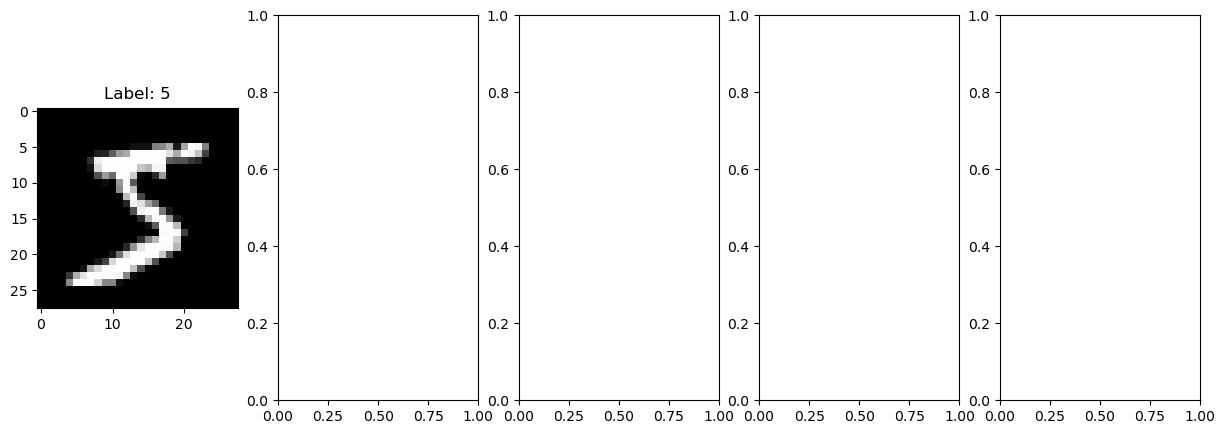

In [5]:
# Create second dataset using the mix func to build negative examples
negative_dataset = PreloadedDataset.from_dataset(raw_dataset, transforms.ToTensor(), device)
print(f'Loaded MNIST with {len(negative_dataset)} samples')

def mix_dataset(dataset):
    for i in range(len(dataset)):
        j = i + 1 if i < len(dataset) - 1 else 0
        dataset.transformed_images[i] = mix_images(dataset.images[i], dataset.images[j])
    return dataset

negative_dataset = mix_dataset(negative_dataset)

# show first samples
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow(np.squeeze(negative_dataset[i][0].numpy()), cmap='gray')
    axs[i].set_title(f"Label: {negative_dataset[i][1]}")
plt.show()


In [6]:
class Model(nn.Module):

    def __init__(self, in_features, out_features, hiddens=[]):
        super(Model, self).__init__()
        self.shape = [in_features] + hiddens + [out_features]
        layers = []
        for h in hiddens:
            layers.append(nn.Linear(h, in_features))
            in_features = h
        layers.append(nn.Linear(out_features, in_features))
        self.layers = nn.ModuleList(layers)

    def init_state(self, batch_size=1):
        E = [torch.zeros((batch_size, self.shape[i])) for i in range(len(self.shape)-1)]
        R = [torch.zeros((batch_size, self.shape[i+1])) for i in range(len(self.shape)-1)]
        return [E,R]

    def step(self, x, state=None):
        if state is None:
            state = self.init_state(len(x))
        else:
            for i in range(len(self.layers)):
                state[0][i] = state[0][i].detach()
                state[1][i] = state[1][i].detach()

        with torch.no_grad():
            for i in range(len(self.layers)):
                pred = self.layers[i](state[1][i])
                state[0][i] = x - pred if i==0  else state[1][i-1] - pred
        for i in range(len(self.layers)):
            state[1][i] = state[1][i] + F.linear(state[0][i], self.layers[i].weight.T)
        return state

    def forward(self, x, state=None, steps=20):
        for _ in range(steps):
            state = self.step(x, state)
        return state

In [51]:
def measure_errs(
        model,
        dataloader,
):
    E = [0.0 for _ in range(len(model.layers))]

    for batch_idx, (images, _) in enumerate(dataloader):
        images = images.flatten(start_dim=1)
        state = model(images, steps=5)
        for i, e in enumerate(state[0]):
            E[i] += e.abs().mean()
    
    for i in range(len(E)):
        E[i] /= batch_idx+1

    return E

def train(
        model,
        positive_dataset,
        negative_dataset,
        batch_size,
        lr,
        epochs,
        measure_errs_every=1,
        step=0,
):
    # writer = SummaryWriter("Deep_Learning/Experimental/Hebbian_Learning/mnist/out/logs")
    Es = [[] for _ in range(len(model.layers))]
    layer_reg_coeff = [0.3, 0.1]
    positive_dataloader = torch.utils.data.DataLoader(positive_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        negative_dataset = mix_dataset(negative_dataset)
        negative_dataloader = torch.utils.data.DataLoader(negative_dataset, batch_size=batch_size, shuffle=True)
        
        # For some dumb reason, i have to reinitialise the loop every epoch
        loop = tqdm(enumerate(positive_dataloader), total=len(positive_dataloader), leave=False) 

        neg_it = iter(negative_dataloader)
        for batch_idx, (images, y) in loop:
            images = images.flatten(start_dim=1)

            for phase in range(2):
                phase_coeff = 1.0
                if phase == 1: # Negative phase
                    continue
                    # images = torch.randn_like(images)
                    images = next(neg_it)[0].flatten(start_dim=1)
                    phase_coeff = -0.5

                state = model.init_state(len(images))
                for step_i in range(4):
                    state = model.step(images, state)
                    if step_i > 0:
                        model.zero_grad()
                        reg = -1.0 * sum(l.weight.square().mean() for l in model.layers)
                        reg.backward()
                        
                        for i in range(len(model.layers)):
                            model.layers[i].weight.grad += -state[0][i].T @ state[1][i]
                            model.layers[i].weight.grad /= len(images)
                            # print(f'epoch: {epoch}, batch: {batch_idx}, layer: {i}, phase: {phase}, step: {step_i}')
                            # print(f'e_mag: {state[0][i].abs().mean()}, r_mag: {state[1][i].abs().mean()}')
                            # print(model.layers[i].weight.grad.abs().mean())
                            model.layers[i].weight.data += phase_coeff*lr*model.layers[i].weight.grad

            step += len(images)

        if epoch % measure_errs_every == 0:
            E = measure_errs(model, positive_dataloader)
            for i, e in enumerate(E):
                Es[i].append(e)

    return Es, step

In [67]:
positive_dataset[0][0].flatten().mean()

tensor(0.0227)

In [58]:
model = Model(784, 64, [])
for layer in model.layers:
    layer.weight.data *= 0.01
step = 0

In [11]:
batch_size = 4
dataloader = torch.utils.data.DataLoader(positive_dataset, batch_size=batch_size, shuffle=True)
x = next(iter(dataloader))[0].flatten(start_dim=1)
state = model.init_state(len(x))

state = model.step(x, state)
state = model.step(x, state)
state = model.step(x, state)
state = model.step(x, state)
state = model.step(x, state)
state = model.step(x, state)

for i in range(len(model.layers)):
    print(f'layer: {i}, e_mag: {state[0][i].abs().mean()}, r_mag: {state[1][i].abs().mean()}')


layer: 0, e_mag: 0.717157781124115, r_mag: 0.04973415285348892
layer: 1, e_mag: 0.058073725551366806, r_mag: 0.0022778718266636133
layer: 2, e_mag: 0.06193847954273224, r_mag: 0.0026818341575562954


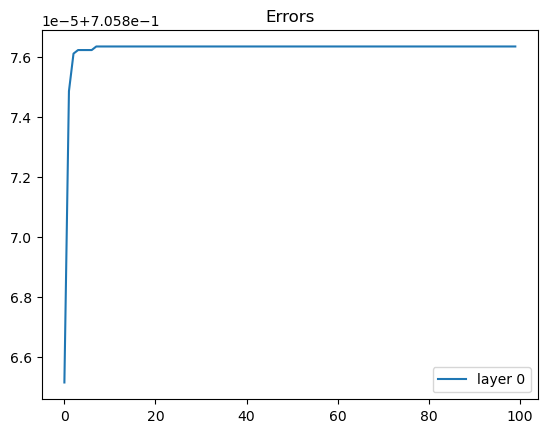

In [57]:
batch_size = 1
lr = 0.0001
optimiser = torch.optim.AdamW(model.parameters(), lr, weight_decay=1.0)
epochs=100
Es, step = train(
    model,
    positive_dataset,
    negative_dataset,
    batch_size,
    lr,
    epochs,
    step=step,
)
# plot logarithmic
for i, e in enumerate(Es):
    plt.plot(e, label=f'layer {i}')
# plt.yscale('log')
plt.legend()
plt.title('Errors')
plt.show()

In [79]:
for i, e in enumerate(Es):
    print(max(e))

tensor(2.2823e+28)


In [ ]:
for layer in model.layers:
    print(layer.weight.abs().mean(), layer.bias.abs().mean())

tensor(0.0613, grad_fn=<MeanBackward0>) tensor(0.0634, grad_fn=<MeanBackward0>)
tensor(0.0312, grad_fn=<MeanBackward0>) tensor(0.0274, grad_fn=<MeanBackward0>)


In [ ]:
positive_sample = positive_dataset[0][0].flatten().unsqueeze(0)
negative_sample = negative_dataset[0][0].flatten().unsqueeze(0)
random_sample = torch.randn_like(positive_sample)

out1 = model(positive_sample)
out2 = model(negative_sample)
out3 = model(random_sample)

print(out1[0][0].abs().mean())
print(out1[0][1].abs().mean())
print(out2[0][0].abs().mean())
print(out2[0][1].abs().mean())
print(out3[0][0].abs().mean())
print(out3[0][1].abs().mean())


tensor(1.0533)
tensor(2.9642)
tensor(1.0847)
tensor(2.9922)
tensor(0.9877)
tensor(2.7128)
